# 3 图像灰度值变换

灰度值 (intensity)

### 二值化

二值化 (binarize) 把图像每个像素变成纯黑或纯白的像素.


### 负变换

负变换 (negative) 把灰度值用最大值减, 使得较黑的像素变白, 较白的像素变黑.

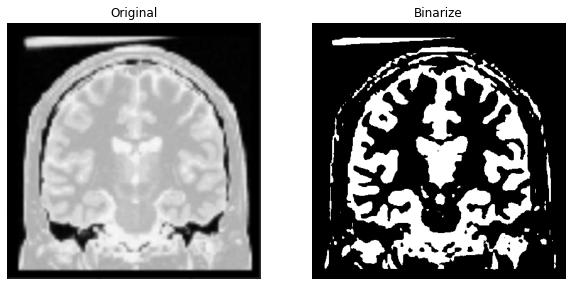

In [31]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
threshold = 200
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\brain.png')).convert('L'))
img_bin = np.where(img > threshold, 1, 0)
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(img_bin, cmap = 'gray')
plt.axis('off')
plt.title('Binarize')
plt.show()

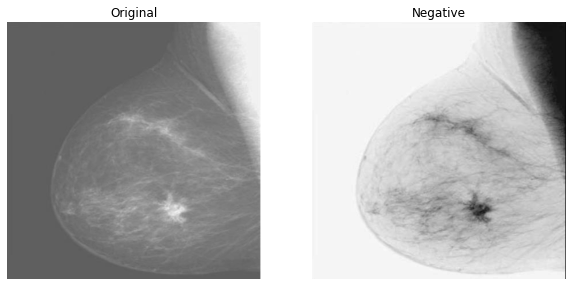

In [30]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
threshold = 200
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\tissue.png')).convert('L'))
img_neg = np.max(img) - img 
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(img_neg, cmap = 'gray')
plt.axis('off')
plt.title('Negative')
plt.show()

## 基于直方图的变换

(Histogram-based transform) 观察灰度值的分布函数 (直方图), 再进行变换.

灰度值在 $[0,255]$ 间均匀分布比较好看.

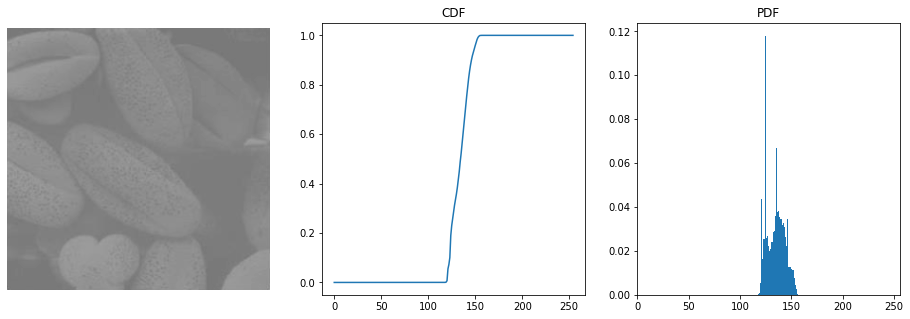

In [6]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
cdf = lambda x: np.array([np.sum(x <= i) for i in range(256)]) / x.size
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\cells.png')).convert('L')).astype('float')
def plotimage(img, bins = 40):
    img = img.clip(0,255).astype('uint8')
    plt.figure(figsize = (16, 5))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.plot(cdf(img))
    plt.title('CDF')
    plt.subplot(1,3,3)
    plt.hist(img.flatten(), bins = bins, density = True)
    plt.xlim(0, 256)
    plt.title('PDF')
    plt.show()
plotimage(img)

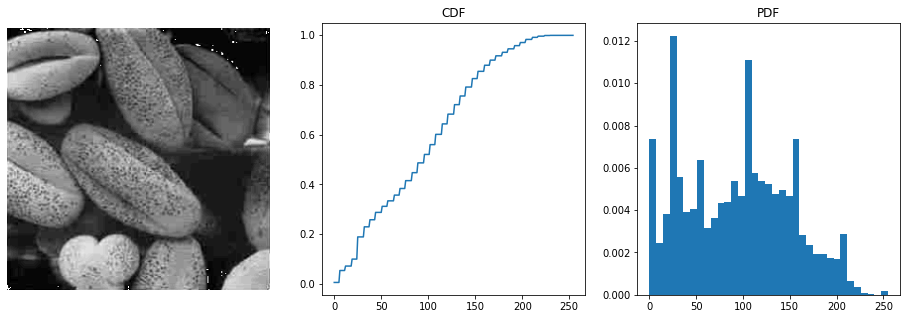

In [47]:
# 将 [120, 160) 的像素仿射拉伸至 [0, 256)
img_trans = (6.4 * (img - 120)).clip(0, 255)
plotimage(img_trans, bins = 35)

### 直方图均衡化

直方图均衡化 (histogram equalization) 变成(接近)真正的均匀分布: 获得每个像素点灰度值的**排名**, 按比例对应到 $[0,255]$

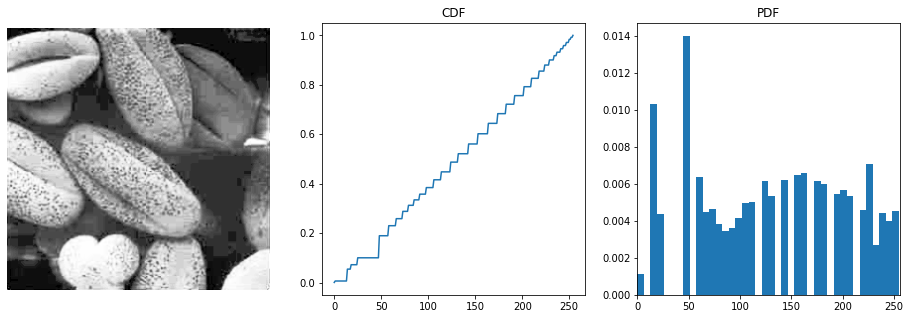

In [16]:
rank = cdf(img)[img.astype('int')]
img_uniform = (rank * 255.)
plotimage(img_uniform)

### 局部直方图处理

先计算图像局部区域的直方图. 判断局部是否需要在局部均衡化.

也可以对每个点计算其局部 (如 $5\times 5$ 范围) 的直方图. 对该点依据此局部直方图进行均衡. 此即局部直方图均衡化 (local histogram equalization).

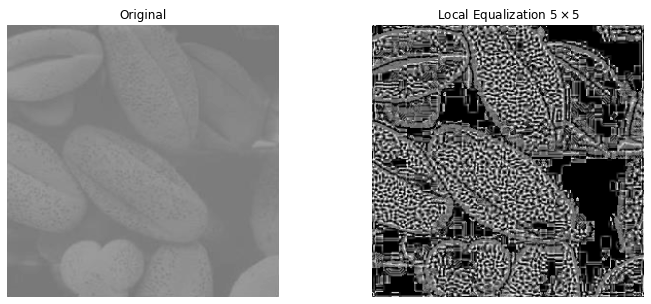

In [4]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\cells.png')).convert('L')) 
def LocalHistogramEqualization(img: np.ndarray, kernel_size: int = 5) -> np.ndarray:
    histogram = np.zeros(256)
    # pad the image to handle the border
    img = np.pad(img, kernel_size//2, 'edge')
    equalization = np.zeros_like(img, dtype='int32')

    def LocalHistogramEqualizationZ(img, histogram, k, equalization):
        n = k // 2 # k is the kernel size while n is half the kernel size
        # begin with the topleft corner
        for i in range(k):
            for j in range(k):
                histogram[img[i,j]] += 1
        equalization[n,n] = np.sum(histogram[0:img[n,n]]) # overwrite the `equalization`
        
        j = n # the center
        dj = 1 # when dj = 1, the kernel moves from left to right; while dj = -1, vise versa
        for h in range(n, img.shape[0] - n):
            for _ in range(img.shape[1] - k - 1):
                # move kernel horizontally
                j += dj 
                for i in range(h-n, h+n+1):
                    histogram[img[i,j+n*dj]] += 1
                    histogram[img[i,j-n*dj-dj]] -= 1

                equalization[h,j] = np.sum(histogram[0:img[h,j]])

            # move down to a new line
            if h + n + 1 < img.shape[0]:
                dj = -dj # alter direction
                for l in range(j-n,j+n+1):
                    histogram[img[h-n,l]] -= 1
                    histogram[img[h+n+1,l]] += 1
                equalization[h+1, j] = np.sum(histogram[0:img[h+1,j]])

    try:
        from numba import njit 
        LocalHistogramEqualizationZ = njit(LocalHistogramEqualizationZ, cache = True)
    except: pass 
    LocalHistogramEqualizationZ(img, histogram, kernel_size, equalization)

    # crop the equalization
    equalization = equalization[kernel_size//2:-kernel_size//2, kernel_size//2:-kernel_size//2]
    
    # scale
    equalization = equalization.astype('float') * (255. / kernel_size ** 2)
    return np.clip(equalization, 0, 255).astype('uint8')


img_lhe = LocalHistogramEqualization(img, kernel_size = 5)
plt.figure(figsize = (12, 5))
for i, _img_, title in zip((1,2), (img, img_lhe), ('Original','Local Equalization $5\\times 5$')):
    plt.subplot(1,2,i)
    plt.imshow(_img_, cmap = 'gray', vmin = 0, vmax = 255)
    plt.title(title)
    plt.axis('off')
plt.show()

## 熵 

熵 (Entropy) 衡量一个概率分布的均匀程度. 
$$H =-\sum_i p_i \log p_i$$

熵也衡量信息量, 信息量越大, 熵就越大.

In [24]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
cdf = lambda x: np.array([np.sum(x <= i) for i in range(256)]) / x.size
pdf = lambda x: np.diff(cdf(x), prepend = 0)
def entropy(img):
    pdf_ = pdf(img)
    pdf_ = np.where(pdf_ < 1e-8, 1, pdf_) # prevent log(0)
    return -np.sum(pdf_ * np.log(pdf_))
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\cells.png')).convert('L')).astype('float')
print('Original  Entropy =', entropy(img))
print('Strenched Entropy =', entropy((6.4 * (img - 120)).clip(0, 255)))
print('Equalized Entropy =', entropy(cdf(img)[img.astype('int')] * 255.))


Original  Entropy = 3.43671310203673
Strenched Entropy = 3.432641910415029
Equalized Entropy = 3.3899648471684287


### 熵图像

对图像每个像素计算局部的熵值, 把所有像素的局部熵绘制成新的图片, 称为熵图像 (entropy image).

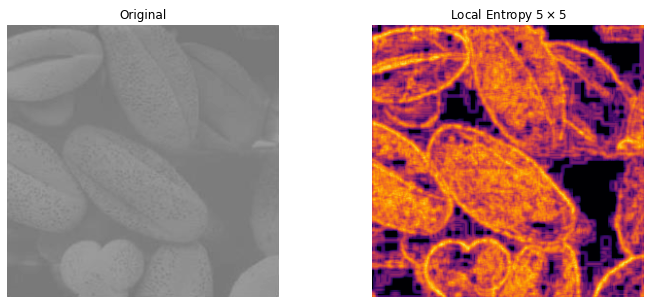

In [9]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\cells.png')).convert('L')) 
def LocalEntropy(img: np.ndarray, kernel_size: int = 5) -> np.ndarray:
    histogram = np.zeros(256)
    # pad the image to handle the border
    img = np.pad(img, kernel_size//2, 'edge')
    entropy = np.zeros_like(img, dtype='float')
    def entropy_of_hist(histogram, s):
        prob = histogram / s
        prob = np.where(histogram == 0, 1, prob)
        return -np.dot(prob, np.log(prob))

    def LocalEntropyZ(img, histogram, k, entropy):
        n = k // 2 # k is the kernel size while n is half the kernel size
        # begin with the topleft corner
        for i in range(k):
            for j in range(k):
                histogram[img[i,j]] += 1
        entropy[n,n] = entropy_of_hist(histogram, k*k)
        
        j = n # the center
        dj = 1 # when dj = 1, the kernel moves from left to right; while dj = -1, vise versa
        for h in range(n, img.shape[0] - n):
            for _ in range(img.shape[1] - k - 1):
                # move kernel horizontally
                j += dj 
                for i in range(h-n, h+n+1):
                    histogram[img[i,j+n*dj]] += 1
                    histogram[img[i,j-n*dj-dj]] -= 1

                entropy[h,j] = entropy_of_hist(histogram, k*k)

            # move down to a new line
            if h + n + 1 < img.shape[0]:
                dj = -dj # alter direction
                for l in range(j-n,j+n+1):
                    histogram[img[h-n,l]] -= 1
                    histogram[img[h+n+1,l]] += 1
                entropy[h+1, j] = entropy_of_hist(histogram, k*k)

    try:
        from numba import njit 
        entropy_of_hist = njit(entropy_of_hist, cache = True)
        LocalEntropyZ = njit(LocalEntropyZ, cache = True)
    except: pass 
    LocalEntropyZ(img, histogram, kernel_size, entropy)

    # crop the equalization
    entropy = entropy[kernel_size//2:-kernel_size//2, kernel_size//2:-kernel_size//2]
    
    # scale
    return entropy 


img_entropy = LocalEntropy(img, kernel_size = 5)
plt.figure(figsize = (12, 5))
for i, _img_, title, color, min_, max_ in zip(
    (1,2), (img, img_entropy), ('Original','Local Entropy $5\\times 5$'), ('gray', 'inferno'),
    (0, 0), (255, 3.2)):
    plt.subplot(1,2,i)
    plt.imshow(_img_, cmap = color, vmin = min_, vmax = max_)
    plt.title(title)
    plt.axis('off')
plt.show()

任意排列直方图, 熵不变. 因此两个配色差异很大的图像可能熵图像相似.

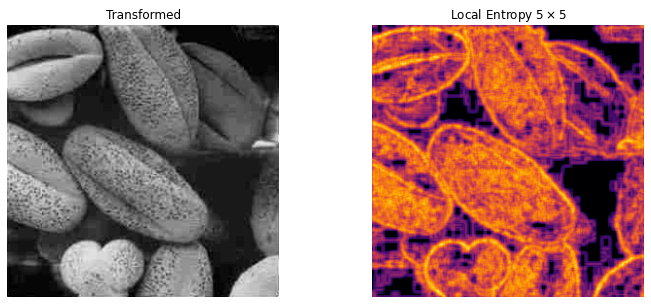

In [14]:
# img2 = np.clip(180 - ((img.astype('float') ** 2) / 255).astype('uint8'), 0, 255)
img2 = (6.4 * (img - 120.)).clip(0, 255).astype('uint8')
img_entropy2 = LocalEntropy(img2, kernel_size = 5)
plt.figure(figsize = (12, 5))
for i, _img_, title, color, min_, max_ in zip(
    (1,2), (img2, img_entropy2), ('Transformed','Local Entropy $5\\times 5$'), ('gray', 'inferno'),
    (0, 0), (255, 3.2)):
    plt.subplot(1,2,i)
    plt.imshow(_img_, cmap = color, vmin = min_, vmax = max_)
    plt.title(title)
    plt.axis('off')
plt.show()